# **AKARI Far Infrared Data**

### **Download data into CSV file**

See WISE notebook for more information on flux, magnitude, and other definitions

#### Importing AKARI far infrared $(60, 90, 140, and 160)\mu m$ bright sources, totaling about 1.5 million data points
##### Gzip files are streamed in, and the flux densities, ra, and dec are outputted into the file akari_data.csv

In [61]:
import pandas as pd

file_paths = [
    '../Data/akari_data/main_v1.txt',
    '../Data/akari_data/main_v2.txt',
    '../Data/akari_data/suppl_v2.txt'
]

main_path = '../Data/akari_data_filtered.csv'

placeholder_values = [-9.99e+01, -9.999e+02]

# Wavelengths corresponding to flux columns
wavelengths = [65, 90, 140, 160]

# Columns to keep by index from each line
# Indices: 2=ra, 3=dec, 9-12=fluxes, 17-20=flux quality flags
usecols = [2, 3, 9, 10, 11, 12, 17, 18, 19, 20]

column_names = [
    'ra', 'dec',
    'flux65', 'flux90', 'flux140', 'flux160',
    'qflag65', 'qflag90', 'qflag140', 'qflag160'
]

frames = []

for path in file_paths:
    df = pd.read_fwf(path, header=None, usecols=usecols)
    df.columns = column_names

    # Replace placeholders with NaNs
    flux_cols = ['flux65', 'flux90', 'flux140', 'flux160']
    df[flux_cols] = df[flux_cols].replace(placeholder_values, pd.NA)

    # Compute peak flux and its corresponding wavelength
    df['peak_flux'] = df[flux_cols].max(axis=1)
    df['peak_wl'] = df[flux_cols].idxmax(axis=1).str.extract(r'(\d+)').astype(float)

    frames.append(df)

# Combine all the data
full_df = pd.concat(frames, ignore_index=True)

# Save to CSV
full_df.to_csv(main_path, index=False)

# **Analyzing the Data**

In [27]:
import csv
import pandas as pd

path = '../Data/akari_data_filtered.csv'
cleaned_path = '../Data/akari_data_protostar_candidate.csv'

data = pd.read_csv(path, low_memory=False)

qflag_cols = ['qflag65', 'qflag90', 'qflag140', 'qflag160']
for col in qflag_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce').astype('Int64')  

peak_wavelength = (((data['peak_wl']==90.0) & (data['qflag140']>1)) | ((data['peak_wl']==65.0) & (data['qflag65']>1)))
low_flux = (data['flux160']<3) & (data['flux65']<3)
p_flux = (data['peak_flux']>3) & (data['peak_flux']<1000) & (data['flux90']!=999.9)

column_names = [
    'ra', 'dec',
    'flux65', 'flux90', 'flux140', 'flux160',
    'qflag65', 'qflag90', 'qflag140', 'qflag160', 'peak_wl', 'peak_flux'
]

final_cond = peak_wavelength & low_flux & p_flux

data_cleaned = data.loc[final_cond, column_names]
data_cleaned.to_csv(cleaned_path, index=False)

\usepackage{siunitx}

The data is being filtered based on the following parameters: the quality flag being greater than two, the peak wavelength being either 140 or 90, the peak flux being greater than $\SI{1}{\jansky}$ 

In [25]:
import pandas as pd
import pandasql as ps
from IPython.display import display, HTML

df = pd.read_csv('../Data/akari_data_protostar_candidate.csv')

query = ("SELECT * FROM df WHERE")

result = ps.sqldf(query, locals())

display(HTML(result.to_html()))

,ra,dec,flux65,flux90,flux140,flux160,qflag65,qflag90,qflag140,qflag160,peak_wl,peak_flux
0,8.05307,61.44538,2.956,3.014,2.145,0.2468,3,3,2,1,90.0,3.014
1,7.64154,0.49309,2.474,3.248,2.862,0.6268,3,3,3,1,90.0,3.248
2,7.71685,24.69628,2.257,3.034,2.784,1.8690,3,3,3,2,90.0,3.034
3,8.19388,6.29517,2.340,3.186,2.891,1.3480,3,3,3,1,90.0,3.186
4,5.25474,-63.28919,2.124,3.670,2.605,0.7823,3,3,3,1,90.0,3.670
5,8.26875,5.60778,2.176,4.041,3.524,0.3712,3,3,2,1,90.0,4.041
6,5.32078,-7.19339,2.147,4.338,3.413,1.0990,3,3,3,1,90.0,4.338
7,7.02391,-25.22842,2.129,5.801,3.068,1.4430,3,3,3,1,90.0,5.801
8,8.13900,-25.76232,2.524,3.201,2.774,1.4950,3,3,3,1,90.0,3.201
9,7.08307,14.52884,2.166,3.444,3.210,0.8748,3,3,3,1,90.0,3.444


In [3]:
ra = 8.76450
dec = 60.77644

# number 20

from astropy.coordinates import SkyCoord
from astropy import units as u

c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
print(c.galactic)

# 4.36508 -9.57422 -> beautiful agn image

<SkyCoord (Galactic): (l, b) in deg
    (120.93272047, -2.03170924)>


Best-fit dust temperature: 19.09 K


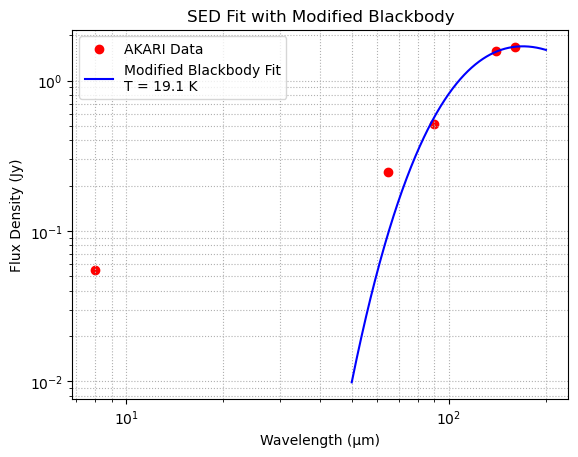

In [29]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from astropy.constants import h, c, k_B

wavelengths = [8, 65, 90, 140, 160]  # μm
fluxes = [0.0547,0.247, 0.51, 1.57, 1.67]  # in Jy (Janskys)

# Convert μm to meters
wavelengths_m = np.array(wavelengths) * 1e-6
fluxes = np.array(fluxes)

# Planck function in Jy
def planck_nu(wavelength, T, norm, beta=1.5):
    nu = c.value / wavelength
    B_nu = (2 * h.value * nu**3 / c.value**2) / (np.exp(h.value * nu / (k_B.value * T)) - 1)
    return norm * (wavelength**(-beta)) * B_nu * 1e26  # convert W/m²/Hz to Jy

# Fit the model
popt, pcov = curve_fit(lambda wl, T, norm: planck_nu(wl, T, norm), wavelengths_m, fluxes, p0=[20, 1e-20])

T_fit, norm_fit = popt
print(f"Best-fit dust temperature: {T_fit:.2f} K")

# Plotting
w_plot = np.linspace(50, 200, 500) * 1e-6
f_plot = planck_nu(w_plot, *popt)

plt.scatter(wavelengths, fluxes, label='AKARI Data', color='red')
plt.plot(w_plot * 1e6, f_plot, label=f'Modified Blackbody Fit\nT = {T_fit:.1f} K', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Wavelength (μm)")
plt.ylabel("Flux Density (Jy)")
plt.title("SED Fit with Modified Blackbody")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()